# Feature engineering

In this notebook, data is going to be preprocessed and grouped by customer for feature extraction. At the end, we will have a train and test dataset, where the later is an out-of-time sample.

Since we have a large dataset, the feature extraction will be performed using **Apache Spark** through the PySparkProcessor class available at SageMaker.

## 1. Preprocessing transactions

Following the exploratory analysis, we need to perform a few preprocessing steps:

- Remove transactions after march 2013

- Remove returns (transactions with negative amount)

- Remove columns that wont be used

- Spliting the data in development (train) and out-of-time (test) samples

- Create the target for each sample

- Save preprocessed datasets to S3

In [5]:
#!python3 -m pip install awswrangler

In [2]:
import io
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sagemaker
import awswrangler as wr
import boto3

# configurations
pd.set_option("max_columns", 99)
sns.set()
colors = sns.color_palette("pastel")

def read_from_s3(bucket, filepath):
    """Read a parquet file from S3 using boto3."""
    buffer = io.BytesIO()
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, filepath)
    obj.download_fileobj(buffer)
    return pd.read_parquet(buffer)

In [6]:
# Read full transactions file from S3
bucket = 'capstone-transaction-data'
df = read_from_s3(bucket, 'raw_data/transactions_sample.parquet')
print(df.shape)

(317376998, 11)


#### Apply filters according to the first three steps:

In [8]:
cols = [
    'id', 'chain', 'dept', 'category', 'company', 'brand',
    'date', 'purchasequantity', 'purchaseamount'
]
mask = (df.date <= 20130331) & (df.purchaseamount > 0)
df = df.loc[mask, cols]
print(df.shape)

(273618974, 9)


#### Spliting the data in train and test

In [9]:
df["date_dt"] = pd.to_datetime(df.date.astype(str), infer_datetime_format=True)

# Threshold for the 90 days observed revenue
test_threshold = df.date_dt.max() - pd.Timedelta(90, unit="days")
train_threshold= test_threshold - pd.Timedelta(90, unit="days")
print(train_threshold, test_threshold)

2012-10-02 00:00:00 2012-12-31 00:00:00


#### Test set files

In [10]:
mask = df["date_dt"] >= test_threshold
test_target = df[mask].groupby("id")["purchaseamount"].sum()
test_target = test_target.to_frame().reset_index()
test_target.columns = ["id", "purchaseamount_90d"]
print(test_target.shape)
test_target.head(3)

(307332, 2)


,id,purchaseamount_90d
0,16802992,283.369995
1,22018852,682.739990
2,22221380,868.640015


In [11]:
test_transactions = df[df["date_dt"] < test_threshold]
print(test_transactions.shape)
test_transactions.head(2)

(206661184, 10)


,id,chain,dept,category,company,brand,date,purchasequantity,purchaseamount,date_dt
1,16802992,18,99,9908,102113020,15704,20120309,1,2.0,2012-03-09
2,16802992,18,99,9908,102113020,15704,20120309,1,2.0,2012-03-09


In [ ]:
# Save preprocessed train data to S3 using AWS Wrangler library
wr.s3.to_parquet(
    df=test_transactions.drop("date_dt", axis=1),
    path="s3://capstone-transaction-data/preprocessed_data/test_transactions.parquet"
)

wr.s3.to_parquet(
    df=test_target,
    path="s3://capstone-transaction-data/preprocessed_data/test_target.parquet"
)

del test_transactions, test_target
gc.collect()

### Train set files

In [13]:
mask = (df["date_dt"] < test_threshold) & (df["date_dt"] >= train_threshold)
train_target = df[mask].groupby("id")["purchaseamount"].sum()
train_target = train_target.to_frame().reset_index()
train_target.columns = ["id", "purchaseamount_90d"]
print(train_target.shape)
train_target.head(3)

(303779, 2)


,id,purchaseamount_90d
0,16802992,205.169998
1,22018852,707.159973
2,22221380,799.539978


In [14]:
train_transactions = df[df["date_dt"] < train_threshold]
print(train_transactions.shape)
train_transactions.head(2)

(140440668, 10)


,id,chain,dept,category,company,brand,date,purchasequantity,purchaseamount,date_dt
1,16802992,18,99,9908,102113020,15704,20120309,1,2.0,2012-03-09
2,16802992,18,99,9908,102113020,15704,20120309,1,2.0,2012-03-09


In [ ]:
wr.s3.to_parquet(
    df=train_transactions.drop("date_dt", axis=1),
    path="s3://capstone-transaction-data/preprocessed_data/train_transactions.parquet"
)

wr.s3.to_parquet(
    df=train_target,
    path="s3://capstone-transaction-data/preprocessed_data/train_target.parquet"
)

## 2. Feature Engineering using Spark

In order to build a Lifetime Revenue (LTR) model, we need to aggregate the data at the customer-level and extract features from the 320 million transactions available. This will be done using Pyspark through SageMaker's PySparkProcessor class. The pyspark script is located at *spark/feature_eng.py*

In [4]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
input_bucket = "capstone-transaction-data"
input_key = "preprocessed_data/test_transactions.parquet"
output_bucket = "capstone-transaction-data"
output_key = "processed_data/test_features.parquet"

In [10]:
from sagemaker.spark.processing import PySparkProcessor

spark_processor = PySparkProcessor(
    base_job_name="spark-feature-engineering",
    framework_version="2.4",
    role=role,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    max_runtime_in_seconds=1200,
    volume_size_in_gb=60,
)

spark_processor.run(
    submit_app="spark/feature_eng.py",
    logs=False,
    arguments=['--s3_input_bucket', input_bucket,
               '--s3_input_key', input_key,
               '--s3_output_bucket', output_bucket,
               '--s3_output_key', output_key]
)


Job Name:  spark-feature-engineering-2021-07-27-18-44-12-065
Inputs:  [{'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-165065549497/spark-feature-engineering-2021-07-27-18-44-12-065/input/code/feature_eng.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  []
........................................................................................................................................!

## 3. Feature analysis

In this section we will look at the resulting features with a multivariate analysis.

In [5]:
# Read train and test features and join with target
train = read_from_s3(output_bucket, "processed_data/train_features.parquet")
train_target = read_from_s3(output_bucket,"preprocessed_data/train_target.parquet")

train = train.merge(train_target, on="id", how="left")
train.rename({"purchaseamount_90d": "target"}, axis=1, inplace=True)
train["target"].fillna(0, inplace=True)

test = read_from_s3(output_bucket, "processed_data/test_features.parquet")
test_target = read_from_s3(output_bucket,"preprocessed_data/test_target.parquet")

test = test.merge(test_target, on="id", how="left")
test.rename({"purchaseamount_90d": "target"}, axis=1, inplace=True)
test["target"].fillna(0, inplace=True)

print(train.shape, test.shape)
train.head(2)

(288081, 51) (305007, 51)


,id,num_unique_date,max_transaction_amount,sum_amount,avg_transaction_amount,std_transaction_amount,chain,num_unique_dept,num_unique_brand,days_since_last_transaction,days_since_first_transaction,avg_daily_amount,unique_dates_to_days,avg_date_amount,std_date_amount,unique_dates_180d,transactions_count_180d,purchase_amount_sum_180d,avg_transaction_amount_180d,purchasequantity_sum_180d,time_weighted_amount_180d,unique_dates_90d,transactions_count_90d,purchase_amount_sum_90d,avg_transaction_amount_90d,purchasequantity_sum_90d,time_weighted_amount_90d,unique_dates_60d,transactions_count_60d,purchase_amount_sum_60d,avg_transaction_amount_60d,purchasequantity_sum_60d,time_weighted_amount_60d,unique_dates_30d,transactions_count_30d,purchase_amount_sum_30d,avg_transaction_amount_30d,purchasequantity_sum_30d,time_weighted_amount_30d,recency,dslt_to_recency,dslt_to_dsft,recency_to_unique_dates,dslt_to_rtud,sum_amount_to_dsft,sum_amount_to_recency,amount_30_to_180_rate,amount_60_to_180_rate,amount_90_to_180_rate,amount_30_to_90_rate,target
0,12262064,120,65.959999,2295.729980,4.114212,4.54858,95,65,218,1,213,10.778075,0.563380,19.131083,18.765202,109.0,524.0,2132.280029,4.069237,609.0,538.865601,54.0,267.0,1055.380005,3.952734,290.0,319.114532,37.0,185.0,749.809998,4.053027,201.0,249.026154,19.0,93.0,337.389984,3.627849,102.0,140.975647,212,0.004695,0.004695,1.766667,0.361446,10.72771,10.828915,0.158156,0.351482,0.494722,0.319383,838.989990
1,12277270,93,24.980000,3601.310059,5.789887,4.24051,95,55,167,2,210,17.149096,0.442857,38.723763,41.318462,81.0,539.0,3129.820068,5.806716,623.0,840.181580,38.0,262.0,1507.849976,5.755153,310.0,509.219116,24.0,188.0,1091.979980,5.808404,226.0,413.054291,12.0,116.0,660.409973,5.693190,144.0,299.235992,208,0.009569,0.009569,2.236559,0.617940,17.06782,17.313992,0.210938,0.348784,0.481615,0.437691,1505.689941


### 3.1 - Target variable

The target distribution is stable when comparing the train and test samples. As discussed in the exploratory analysis, we can see that customer spending has a non-normal distribution, with a long tail to the right. 

Max train target 15876
Max test target 21908


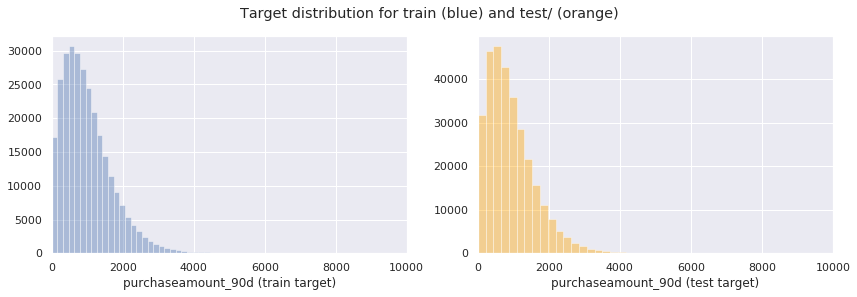

In [4]:
# target distributions (train and test)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Target distribution for train (blue) and test/ (orange)')
sns.distplot(train.target, ax=axes[0], kde=False, bins=100)
sns.distplot(test.target, ax=axes[1], kde=False, color="orange", bins=100)
axes[0].set(xlim=(0, 10000), xlabel='purchaseamount_90d (train target)')
axes[1].set(xlim=(0, 10000), xlabel='purchaseamount_90d (test target)')
print("Max train target", int(train.target.max()))
print("Max test target", int(test.target.max()))

### 3.2 - Churn analysis

The time since the last transaction is an important indicator of churn. The frequency is also relevant here, since less frequent customers might not have churned, but are still in between two following purchases. In the next plot, we are binning this feature and calculating the churn rate for each bin:

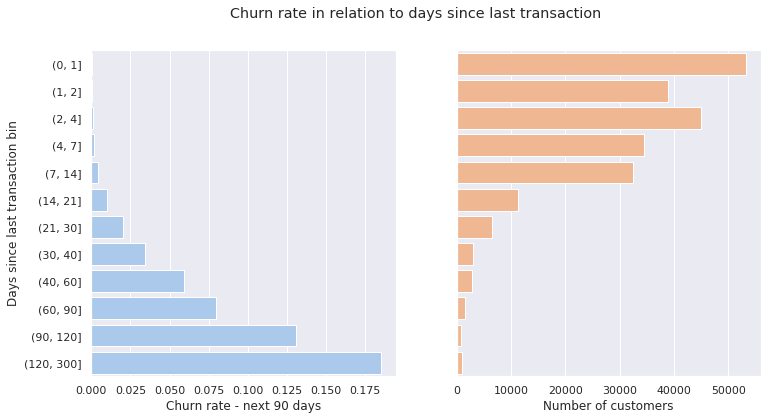

In [5]:
train["churn"] = (train["target"] <= 0).astype("int8")
bins = [0, 1, 2, 4, 7, 14, 21, 30, 40, 60, 90, 120, 300]
train["_cluster"] = pd.cut(train.days_since_last_transaction,
                           bins=bins, duplicates="drop")
churn_rate = train.groupby("_cluster")["churn"].mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
fig.suptitle('Churn rate in relation to days since last transaction')
_ = sns.barplot(y=churn_rate.index, x=churn_rate.values,
                color=colors[0], ax=axes[0])
sns.countplot(y=train["_cluster"], ax=axes[1], color=colors[1])
_ = axes[0].set(xlabel='Churn rate - next 90 days',
                ylabel="Days since last transaction bin")
_ = axes[1].set(xlabel='Number of customers', ylabel="")

In the next plot we do the same analysis, but now using a **ratio** between the number of **days since the last transaction** and the **average number of days between transactions**:

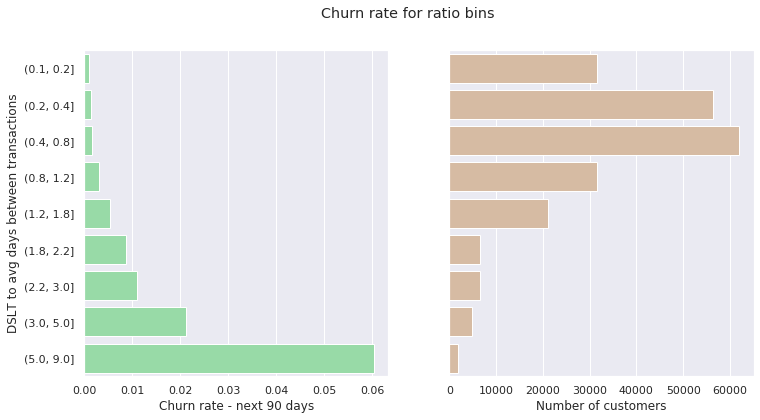

In [28]:
bins = [0.1, 0.2, 0.4, 0.8, 1.2, 1.8, 2.2, 3, 5, 9]
train["_cluster"] = pd.cut(train.dslt_to_rtud, bins=bins, duplicates="drop")
churn_rate = train.groupby("_cluster")["churn"].mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
fig.suptitle('Churn rate for ratio bins')
_ = sns.barplot(y=churn_rate.index, x=churn_rate.values, color=colors[2], ax=axes[0])
sns.countplot(y=train["_cluster"], ax=axes[1], color=colors[5])
_ = axes[0].set(xlabel='Churn rate - next 90 days',
                ylabel="DSLT to avg days between transactions")
_ = axes[1].set(xlabel='Number of customers', ylabel="")

### 3.3 - Correlation between features

We can use spearman to check the ranked correlation between features. Window features were removed for a better visualization:

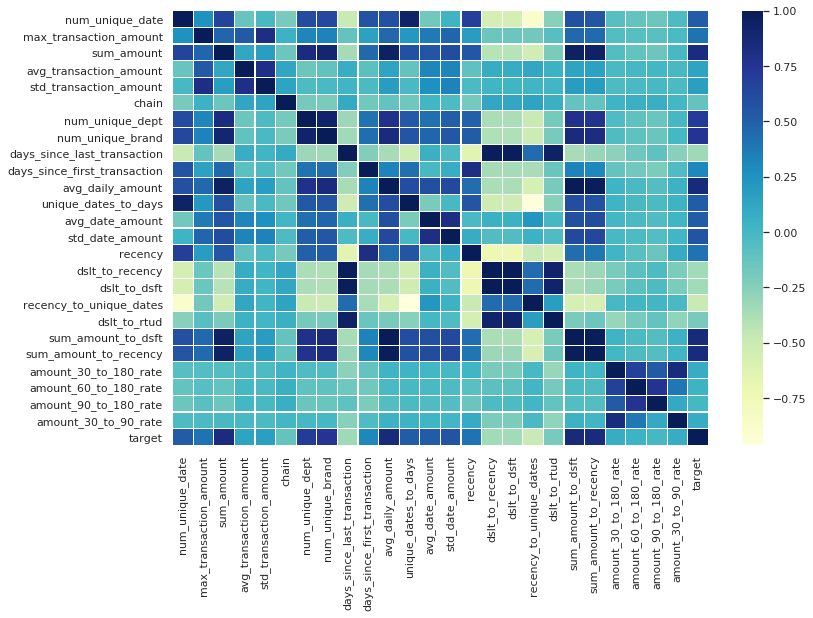

In [10]:
drops = [c for c in train.columns if c[-2:] == "0d" or c == "churn"] + ["id", "_cluster"]
features = [c for c in train.columns if c not in drops]
corr = train[features].corr(method='spearman')
plt.figure(figsize=(12, 8))
_ = sns.heatmap(corr, annot=False, linewidths=.1, cmap="YlGnBu")

We can see a high correlation between the total amount and the target, but an even higher correlation when we divide the total amount with the number of days since the first transaction (or also to recency).

### 3.4 - Bivariate analysis

### Sum amount and related features

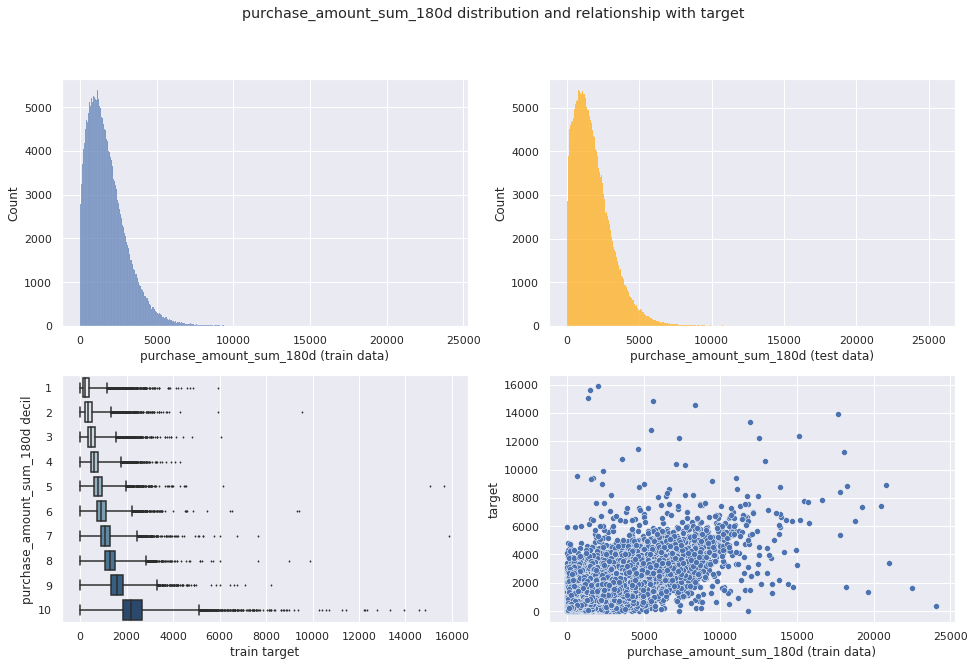

In [25]:
def plot_feature(feature, q=10, num_labels=10):
    x_train = train[~train[feature].isin([np.nan, np.inf])]
    x_test = test[~test[feature].isin([np.nan, np.inf])]
    labels = [str(i+1) for i in range(num_labels)]
    x_train["decil"] = pd.qcut(train[feature], q=q, labels=labels,
                               precision=1, duplicates="drop")
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    fig.suptitle('{} distribution and relationship with target'.format(feature))
    sns.histplot(x_train[feature], ax=axes[0])
    sns.histplot(x_test[feature], ax=axes[1], color="orange")
    sns.boxplot(y="decil", x="target", data=x_train, ax=axes[2],
                whis=3, fliersize=1, saturation=0.5, palette="Blues")
    sns.scatterplot(x=feature, y="target", ax=axes[3], data=x_train)
    axes[0].set(xlabel='{} (train data)'.format(feature))
    axes[1].set(xlabel='{} (test data)'.format(feature))
    axes[2].set(xlabel='train target'.format(feature),
                ylabel="{} decil".format(feature))
    axes[3].set(xlabel='{} (train data)'.format(feature))


plot_feature("purchase_amount_sum_180d")

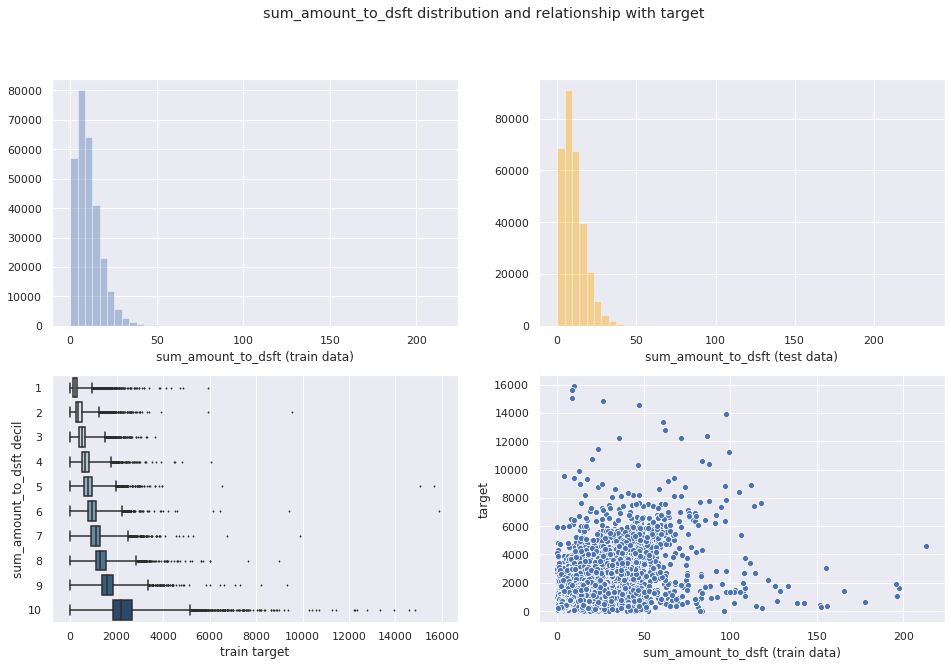

In [58]:
plot_feature("sum_amount_to_dsft")

### Recency and unique_dates

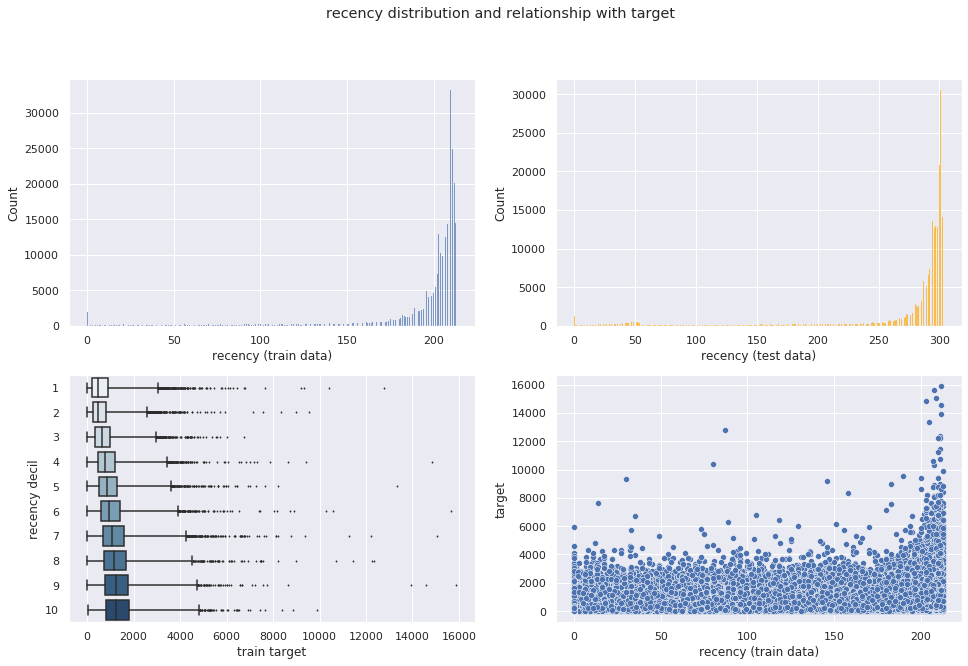

In [39]:
plot_feature("recency")

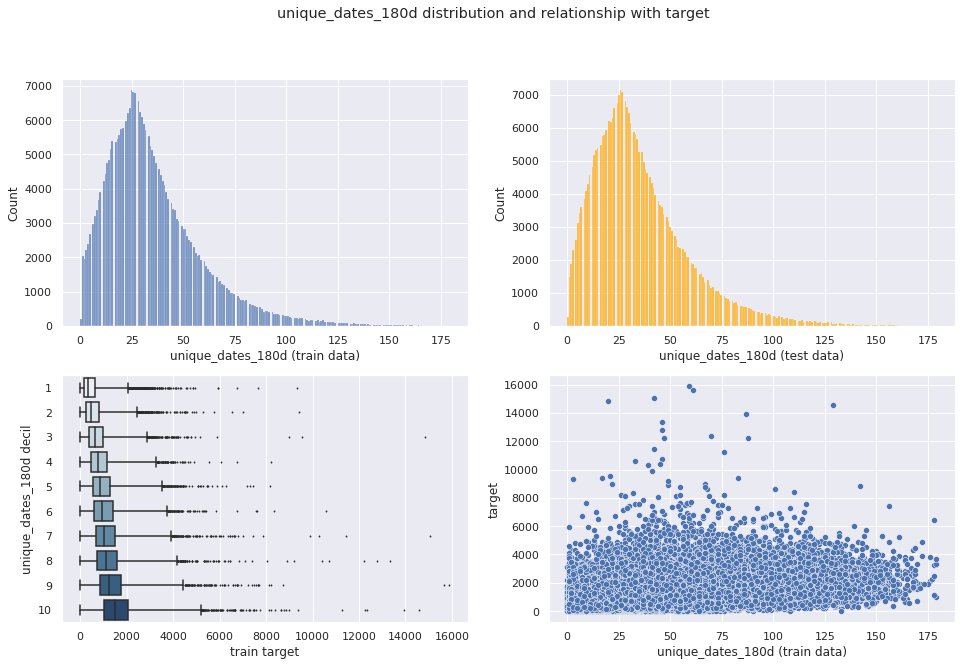

In [28]:
plot_feature("unique_dates_180d")

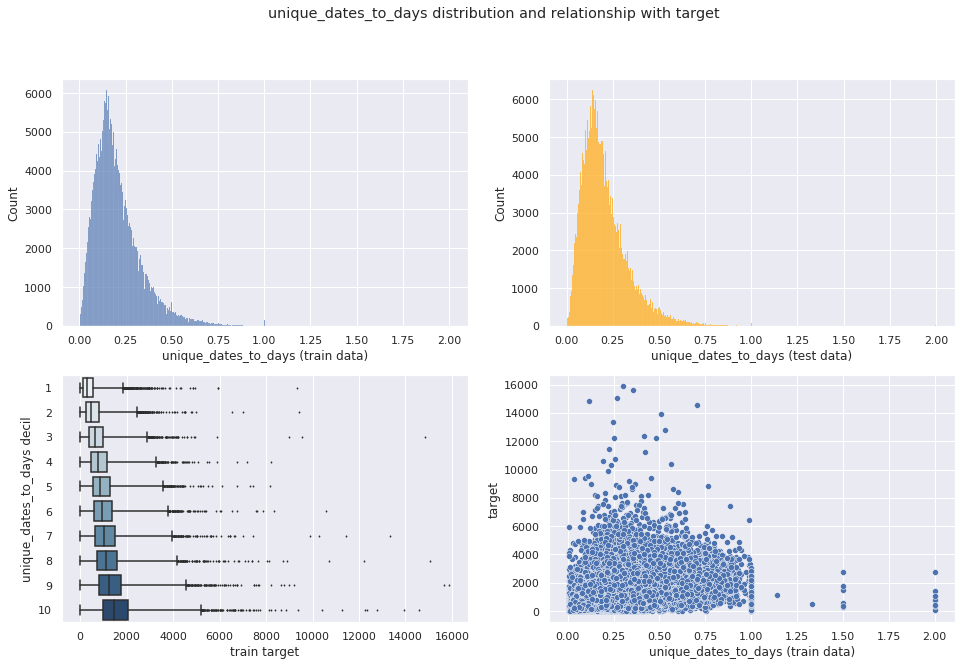

In [38]:
plot_feature("unique_dates_to_days")

### Unique dates, depts and brands

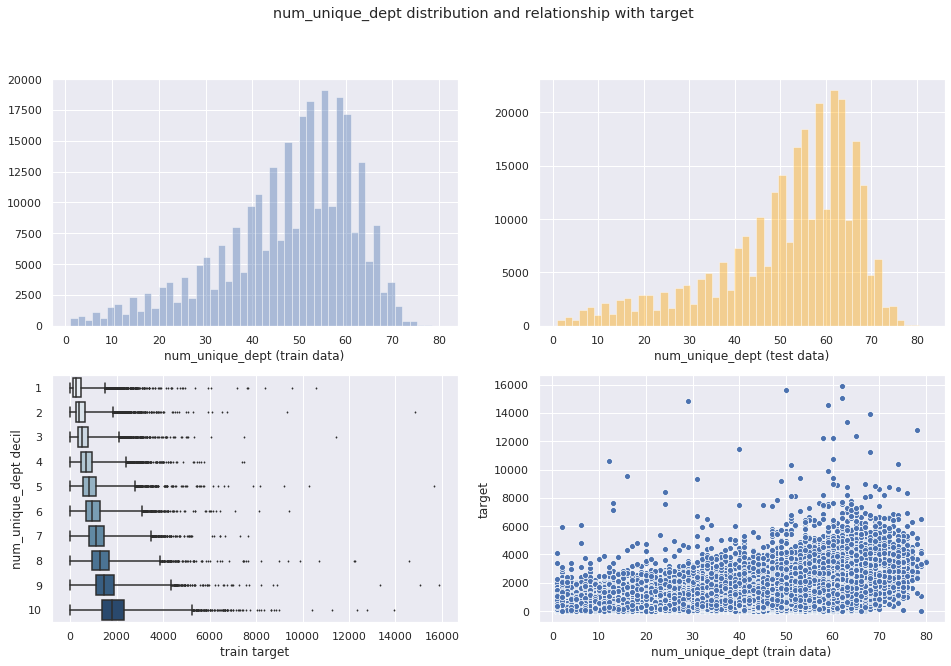

In [48]:
plot_feature("num_unique_dept")

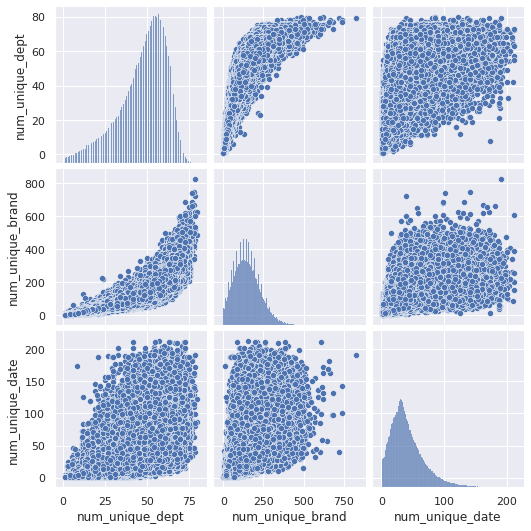

In [34]:
cols = ["num_unique_dept", "num_unique_brand", "num_unique_date"]
_ = sns.pairplot(train[cols])

### Rate between features

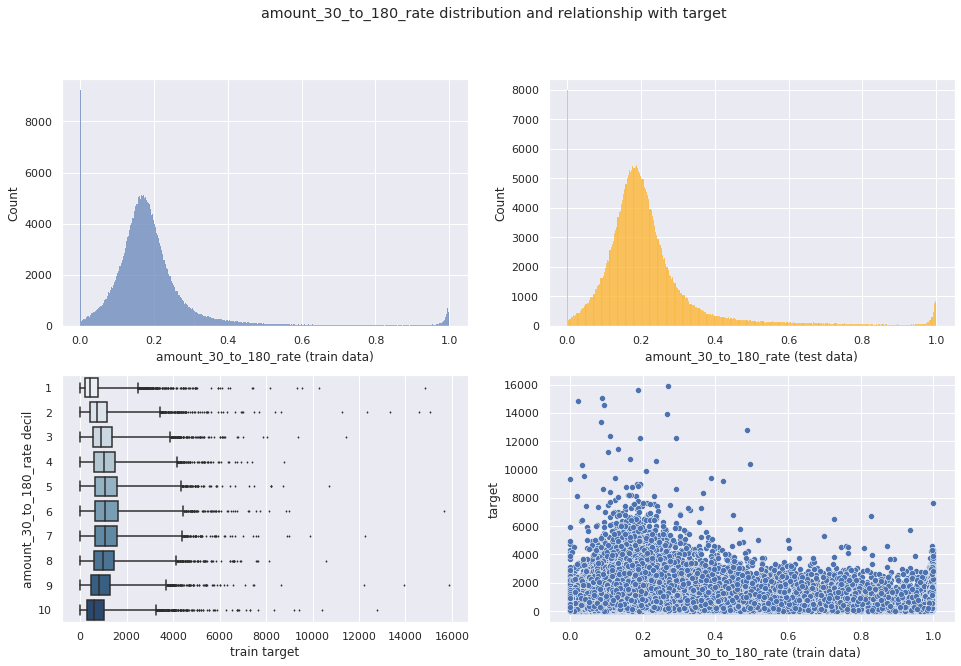

In [43]:
plot_feature("amount_30_to_180_rate")

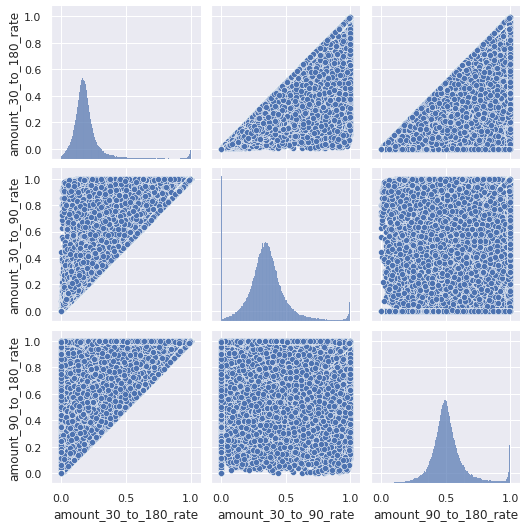

In [44]:
cols = ["amount_30_to_180_rate", "amount_30_to_90_rate", "amount_90_to_180_rate"]
_ = sns.pairplot(train[cols])